In [76]:
"""
The following is an import of PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

In [53]:
"""
Determine if any GPUs are available
"""
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [70]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*24*24, zDim=256):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.conv1 = nn.Conv2d(imgChannels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, imgChannels, kernel_size=3, stride=2, padding=1)
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):
        print('x size',x.size())

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        print(x.size())
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        print('size ', x.size())
        x = x.view(-1, 32*24*24)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 24, 24)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [71]:
from dataset import get_df, get_transforms, MelanomaDataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler



In [72]:
def run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx):

    df_train = df[df['fold'] != fold]
    df_valid = df[df['fold'] == fold]

    dataset_train = MelanomaDataset(df_train, 'train', meta_features, transform=transforms_train)
    dataset_valid = MelanomaDataset(df_valid, 'valid', meta_features, transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, sampler=RandomSampler(dataset_train), num_workers=10,drop_last=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=2, num_workers=10,drop_last=True)

    return train_loader,valid_loader

In [75]:

df, df_test, meta_features, n_meta_features, mel_idx = get_df(
    kernel_type='9c_meta_b3_768_512_ext_18ep',
    out_dim=4,
    data_dir='./data/',
    data_folder=768,
    use_meta=False,
)

transforms_train, transforms_val = get_transforms(image_size=512)
fold='0,1,2'
folds = [int(i) for i in fold.split(',')]
learning_rate = 1e-3
num_epochs = 1

net = VAE(imgChannels=3).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for fold in folds:
    train_loader, valid_loader=run(fold, df, meta_features, n_meta_features, transforms_train, transforms_val, mel_idx)
    for epoch in range(num_epochs):
        for idx, data in enumerate(train_loader, 0):
            imgs, _ = data
            imgs = imgs.to(device)
            print('input size',imgs.size())
            # Feeding a batch of images into the network to obtain the output image, mu, and logVar
            out, mu, logVar = net(imgs)
            print('out size',out.size())
            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
            imgs_=F.interpolate(imgs, size=(32, 32), mode='bilinear', align_corners=False)
            loss = F.binary_cross_entropy(out, imgs_, size_average=False) + kl_divergence

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Fold{}: Epoch {}: Loss {}'.format(fold, epoch, loss))

input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24])
out size torch.Size([2, 3, 32, 32])


/home/changquan/anaconda3/envs/isic/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24])
out size torch.Size([2, 3, 32, 32])
input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24])
out size torch.Size([2, 3, 32, 32])
input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24])
out size torch.Size([2, 3, 32, 32])
input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24])
out size torch.Size([2, 3, 32, 32])
input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24])
out size torch.Size([2, 3, 32, 32])
input size torch.Size([2, 3, 512, 512])
x size torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 32, 32])
size  torch.Size([2, 32, 24, 24]

KeyboardInterrupt: 

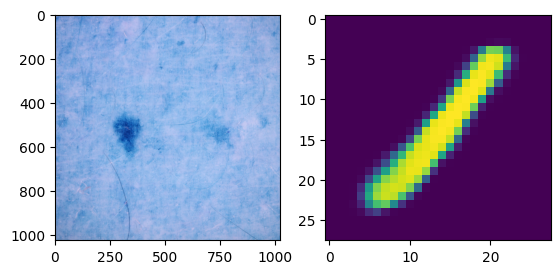

In [12]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        # imgs, _ = data
        # print('type imgs',type(imgs))
        # # imgs = cv2.imread(row.filepath)
        # print(imgs)
        # imgs = imgs.to(device)
        # img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        img = cv2.imread('/home/changquan/code/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution/data/jpeg-melanoma-1024x1024/train/ISIC_0015719.jpg')
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break